### Pre-requisites
For speed, we are going to import `fastbook` here; but be aware that some functions are defined there, and should be extracted eventually.

In [6]:
#!pip install -Uqq fastbook
import fastbook
from fastbook import *
from fastai.vision.widgets import *

## Gathering Data
One way to get images is from DuckDuckGo.

In [7]:
urls = search_images_ddg('grizzly bear', max_images=100)
len(urls), urls[10]

(100,
 'https://images.creativemarket.com/0.1.0/ps/5747581/910/1429/m2/fpnw/wm1/hjtdkzmsagtfviwzm9oqqke1iocmgkhfw98v2c3ah2r2hk1iys99ryirin1cjojo-.jpg?1548231581&s=6b3d92a6e1ee2dd395db01c8017b3e16')

`download_url()` will create the directories if needed

In [8]:
download_url(urls[0], 'downloads/bear.jpg')


Path('downloads/bear.jpg')

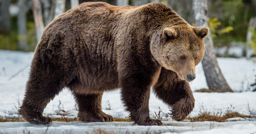

In [9]:
im = Image.open('downloads/bear.jpg')
im.to_thumb(256,256)

Now lets bring a bunch of images and classify them in folders:

In [10]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f"{o} bear", max_images=100)
        download_images(dest=dest, urls=results)

Now we will get the local path of every image file:

In [11]:
fns = get_image_files(path)
fns

(#279) [Path('bears/teddy/00000023.jpg'),Path('bears/teddy/00000090.jpeg'),Path('bears/teddy/00000008.jpg'),Path('bears/teddy/00000004.jpeg'),Path('bears/teddy/00000070.jpg'),Path('bears/teddy/00000045.jpg'),Path('bears/teddy/00000049.jpg'),Path('bears/teddy/00000097.jpg'),Path('bears/teddy/00000061.jpg'),Path('bears/teddy/00000001.jpg')...]

Verify Images: find those that cannot  be opened, so they can be removed from the dataset

In [12]:
failed = verify_images(fns)
failed

(#0) []

Remove those images from the dataset:

In [13]:
failed.map(Path.unlink);

We can verify again... it should be empty this time.

In [14]:
fns = get_image_files(path)
failed = verify_images(fns)
failed

(#0) []

We ultimately want to generate a DataLoader?

In [15]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [16]:
dls = bears.dataloaders(path)
dls?

Type:        DataLoaders
String form: <fastai.data.core.DataLoaders object at 0x7f5144ba72b0>
Length:      2
File:        ~/.local/lib/python3.9/site-packages/fastai/data/core.py
Docstring:   Basic wrapper around several `DataLoader`s.


Lets look at one batch of images grouped by the `DataLoaders` `dls`:

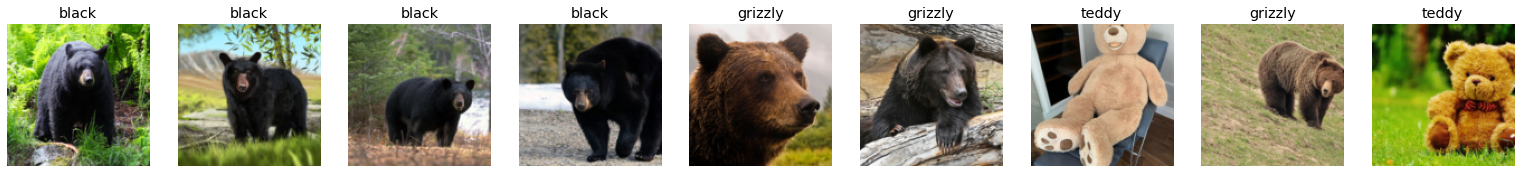

In [17]:
dls.valid.show_batch(nrows=1)

It appears that `dls` has all the data loaded as instructed by the `DataBlock` (`bears` in this case). So if we want to reload the data with different instructions, we need to modify `bears` and reload the images according to that new definition.

Lets say we want to avoid cut images (because the `Resize` function crops by default to get the image of the specified size)

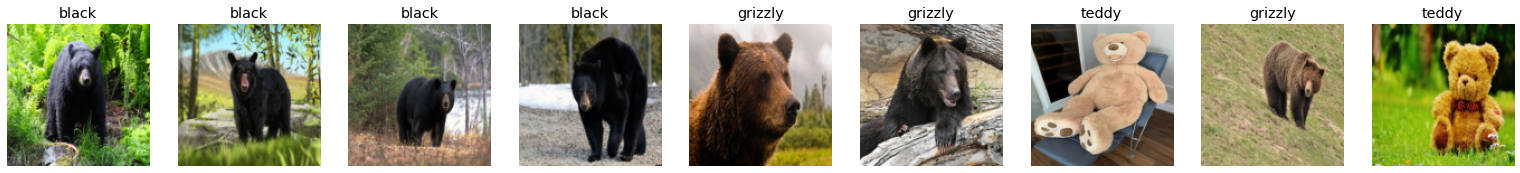

In [18]:
bears = bears.new(item_tfms=Resize(size=128, method=ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(nrows=1)

Alternatively, we can pad with zeroes and keep the original aspect ratio:

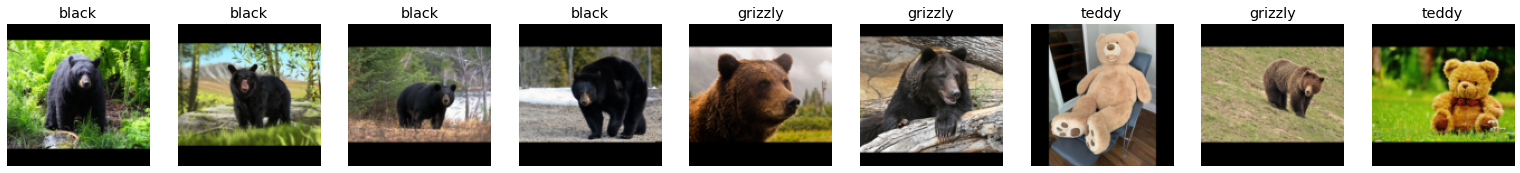

In [19]:
bears = bears.new(item_tfms=Resize(size=128, method=ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(nrows=1)

None of the previous alternatives are desirable because it leads the model to learn that things look different that how they actually are.
In practice we choose to crop a random part of the image on each epoch. That way the model will learn to recognize different features of the images.

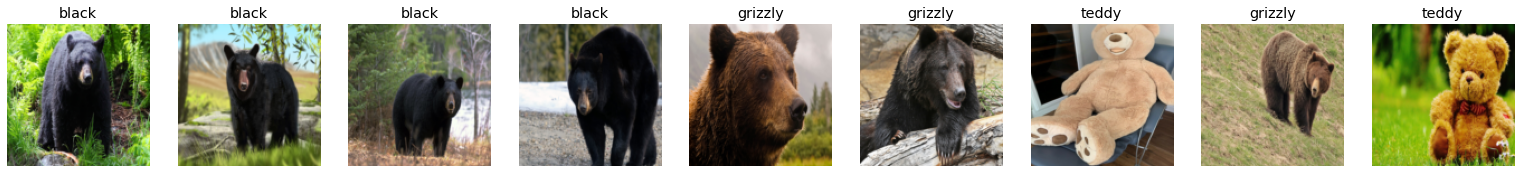

In [20]:
bears = bears.new(item_tfms=RandomResizedCrop(size=128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.valid.show_batch(nrows=1)


We can see how one image will be randomly cropped on each epoch by adding the parameter `unique=true` to the `show_batch` function:

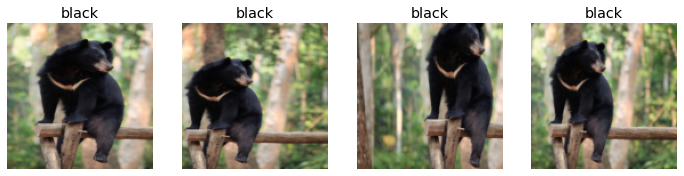

In [21]:
dls.train.show_batch(max_n=4, nrows=1, unique=true)

### Data Augmentation
*Data augmentation* refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes.

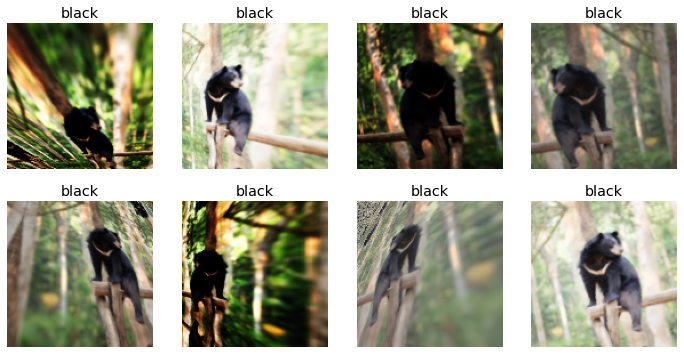

In [22]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=true)

## Traning Your Model, and Using it to Clean Your Data

Using `resnet18` architecture, with `error_rate` as metric, over an augmented dataset:

In [23]:
bears = bears.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.127570,1.549369,0.381818,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.404816,0.247244,0.127273,00:19
1,0.274636,0.040720,0.018182,00:17
2,0.192874,0.055980,0.018182,00:22
3,0.144042,0.065043,0.018182,00:22


Now lets see how good are the predictions of the model:

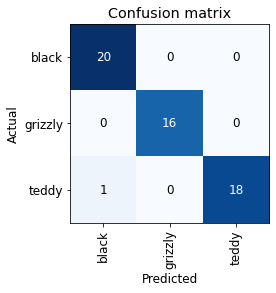

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

To look for problems in our pipeline, it is a good idea to look at the images that generated the highest loss:

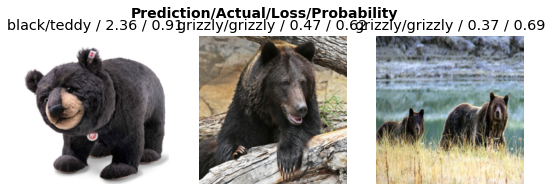

In [25]:
interp.plot_top_losses(3, nrows=1)

FastAI has an GUI tool to clean up the data if needed (e.g. wrong labeling of certain images):

In [26]:
cleaner = ImageClassifierCleaner(learn)
cleaner

`ImageClassifierCleanner` allows to either keep, delete, or move an image from one label to another. But it only keeps the index of those images that need to be deleted/moved. To actually make those changes, we use the indexes:
* Deleting:
```python
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
```

* Moving:
```python
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
```
> s: Cleaning the data and getting it ready for your model are two of the biggest challenges for data scientists; they say it takes 90% of their time. The fastai library aims to provide tools that make it as easy as possible.

### Using the Model for Inference
We need to export the model into a file, which can later on be loaded (presumably on a different machine) to make inferences on input images. Default file name for `export` function is `export.pkl`

In [27]:
learn.export()

Now we can load it back from the file:

In [28]:
path = Path()
learn_inf = load_learner(path/'export.pkl')

In [29]:
learn_inf.predict('downloads/bear.jpg')

('grizzly', TensorBase(1), TensorBase([3.1776e-06, 9.9999e-01, 5.8895e-06]))

### Creating a Notebook App from the Model